# 抽烟行为检测

---

## 目录

- [简介](#简介)
- [数据](#数据)

## 简介

## 数据

### 抽烟视频

In [21]:
from ipywidgets import interact
from matplotlib import pyplot as plt
import ffmpeg
import ipywidgets as widgets
import numpy as np
import cv2

from IPython.display import display, Image, clear_output

In [32]:
path = "/media/alvin/资料/我的文档/数据资料/数据集/smoking/presenceDetection_DingAnHua.mp4"

# path = '/media/alvin/资料/我的文档/数据资料/数据集/smoking/自拍抽烟数据/4f3fa7321577b56952533ffa528312ab.mp4'

In [33]:
probe = ffmpeg.probe(path)
video_info = next(s for s in probe['streams'] if s['codec_type'] == 'video')
width = int(video_info['width'])
height = int(video_info['height'])

print(width, height)
for k in video_info:
    print(k, video_info[k])

2048 1536
index 0
codec_name hevc
codec_long_name H.265 / HEVC (High Efficiency Video Coding)
profile Main
codec_type video
codec_time_base 1/50
codec_tag_string [0][0][0][0]
codec_tag 0x0000
width 2048
height 1536
coded_width 2048
coded_height 1536
has_b_frames 0
sample_aspect_ratio 0:1
display_aspect_ratio 0:1
pix_fmt yuv420p
level 153
color_range tv
refs 1
id 0x1e0
r_frame_rate 25/1
avg_frame_rate 50/1
time_base 1/90000
start_pts 6831035048
start_time 75900.389422
duration_ts 137954970
duration 1532.833000
disposition {'default': 0, 'dub': 0, 'original': 0, 'comment': 0, 'lyrics': 0, 'karaoke': 0, 'forced': 0, 'hearing_impaired': 0, 'visual_impaired': 0, 'clean_effects': 0, 'attached_pic': 0, 'timed_thumbnails': 0}


In [ ]:
%matplotlib inline
# width, height = (300, 400)
from copy import deepcopy
import base64
import time

process1 = (
    ffmpeg
    .input(path)
    .output('pipe:', format='rawvideo', pix_fmt='rgb24')
    .run_async(pipe_stdout=True)
)


while True:
    in_bytes = process1.stdout.read(width * height * 3)
    if not in_bytes:
        break
    in_frame = (
        np
        .frombuffer(in_bytes, np.uint8)
        .reshape([height, width, 3])
    )
    print(in_frame.shape)
    
process1.wait()

In [36]:
def video_format(in_file, out_file, fmt="mp4", pix_fmt="yuv420p", vcodec='h264'):
    return (ffmpeg.input(in_file)
            .output(out_file, format=fmt, pix_fmt=pix_fmt, vcodec=vcodec)
            .run())

In [41]:
path = "/media/alvin/资料/我的文档/数据资料/数据集/smoking/pad_smoking_detect.avi"
out_path = "/media/alvin/资料/我的文档/数据资料/数据集/smoking/pad_smoking_detect_1.mp4"


video_format(path, out_path, vcodec="h264")




(None, None)

### 自拍数据裁剪

In [40]:
cd /opt/git/__faceboxes-master

/opt/git/__faceboxes-master


In [3]:
from __future__ import division
import torch
import cv2

from networks import FaceBox
from encoderl import DataEncoder
import torch.nn.functional as F

from yuetools.utils import model_inference, crop_box_compute


# def model_inference(model, use_gpu=True):
#     if use_gpu is True:
#         model = model.cuda()
#     model.eval()
#     def wrapper(func):
#         def inner_wrapper(input):
#             if use_gpu is True:
#                 input = input.cuda()
#             return func(model(input))
#         return inner_wrapper
#     return wrapper


def encoder():
    en = DataEncoder()
    def wrapper(func):
        def inner_wrapper(im):
            loc, conf = func(im)
            loc, conf = loc.cpu(), conf.cpu()
            
            try:
                boxes, labels, probs = en.decode(
                    loc.data.squeeze(0),
                    F.softmax(conf.squeeze(0), dim=1))
            except:
                print(loc.data.squeeze(0).shape, conf.squeeze(0).shape)
                boxes, labels, probs = en.decode(
                    loc.data.squeeze(0),
                    F.softmax(conf.squeeze(0), dim=1))
            return boxes, probs
        return inner_wrapper
    return wrapper


def load_model():
    net = FaceBox()
    net.load_state_dict(
        torch.load('ckpt/faceboxes.pt', 
                   map_location=lambda storage, loc:storage))
    return net
    
    
model=load_model()

@model_inference(model=model, use_gpu=True)
def process_image(im):
    return im

@encoder()
def faces_extract(im):
    im = cv2.resize(im, (1024,1024))
    im = torch.from_numpy(im.transpose((2,0,1))).float().div(255).unsqueeze(0).cuda()
    return process_image(im)

# def crop_box_compute(shape, box):
#     (h,w) = shape
#     x1 = int(box[0]*w)
#     x2 = int(box[2]*w)
#     y1 = int(box[1]*h)
#     y2 = int(box[3]*h)
#     return x1, x2, y1, y2


def video_faces(video, sample_fps=10):
    cap = cv2.VideoCapture(video)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    
    assert(sample_fps>0)
    print(sample_fps)
    
    if not cap.isOpened():
        print("video cann't open")

    _, frame = cap.read()
    shape = frame.shape[0:2]

    i = 0
    while (True):
        ret,im = cap.read()
        i += 1
        
        if i % sample_fps != 0:
            continue
            
        if ret:
            boxes, probs = faces_extract(im)

            # for box in boxes:
            for i, (box) in enumerate(boxes):
                if bool(probs[i]>0.5):
                    (x1, x2, y1, y2) = crop_box_compute(shape, box)
                    yield im, (x1, x2, y1, y2)
                    
            cv2.waitKey(1)
        else:
            break
    cap.release()  # 关闭相机

In [18]:
%matplotlib inline

import os
import os.path
import matplotlib.pyplot as plt
import tqdm 
import cv2
import shutil


def video_faces_detect(video_path, sample_fps=1, filt=False):
    result_save_root = os.path.splitext(video_path)[0]

    if os.path.exists(result_save_root) is not True:
        os.makedirs(result_save_root)
    else:
        shutil.rmtree(result_save_root)
        os.makedirs(result_save_root)

    for i, (im, (x1, x2, y1, y2)) in tqdm.tqdm(enumerate(video_faces(video_path, sample_fps=sample_fps))):
        w = x2-x1
        h = y2-y1
        if filt is True:
            if h <= 35 and w <=35:
                continue
        im_save_path = os.path.join(result_save_root, "{:d}.jpg".format(i))
        im = im[y1:y2+1,x1:x2+1,:]
        cv2.imwrite(im_save_path, im)

In [20]:
video_root = '/media/alvin/资料/我的文档/数据资料/数据集/smoking/smoking_split.mp4'
video_faces_detect(video_root,sample_fps=3)

1it [00:00,  9.68it/s]

1


6424it [02:01, 52.74it/s]


In [ ]:
import os.path


video_root = '/media/alvin/资料/我的文档/数据资料/数据集/smoking/自拍抽烟数据/train'

_,_, files = next(os.walk(video_root))


video_paths = [os.path.join(video_root, file) for file in files if os.path.splitext(file)[-1] in [".mp4"]]

for video_path in video_paths:
    print("processing:", os.path.split(video_path)[-1], end=" ")
    
    video_faces_detect(video_path)

/media/alvin/资料/我的文档/数据资料/数据集/smoking/自拍抽烟数据/2/4f3fa7321577b56952533ffa528312ab/0.jpg


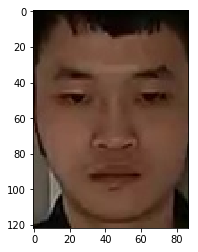

In [9]:
import matplotlib.pyplot as plt
import cv2

idx = 0

video_path = '/media/alvin/资料/我的文档/数据资料/数据集/smoking/自拍抽烟数据/train/4f3fa7321577b56952533ffa528312ab.mp4'

result_save_root = os.path.splitext(video_path)[0]
im_read_path = os.path.join(result_save_root, "{:d}.jpg".format(idx))

print(im_read_path)

im = cv2.imread(im_read_path, cv2.IMREAD_UNCHANGED)
im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)


plt.imshow(im)

In [16]:
%matplotlib inline

import os
import os.path
import matplotlib.pyplot as plt
import tqdm 
import cv2
import shutil

def video_file_faces_detect(root, file, label, sample_fps=1):
    video_file = os.path.join(video_root, file+".mp4")
    
    save_path = os.path.join(video_root, str(label))
    if os.path.exists(save_path) is not True:
        os.makedirs(save_path)

    for i, (im, (x1, x2, y1, y2)) in tqdm.tqdm(enumerate(video_faces(video_file, sample_fps=sample_fps))):
        w = x2-x1
        h = y2-y1
        if h <= 45 and w <=45:
            continue
        im_save_path = os.path.join(save_path, "{file}_{index:d}.jpg".format(index=i, file=file))
        im = im[y1:y2+1,x1:x2+1,:]
        cv2.imwrite(im_save_path, im)

In [17]:
import os.path
import json
from yuetools.utils import load_json

video_root = '/media/alvin/资料/我的文档/数据资料/数据集/smoking/自拍抽烟数据/val'

label_path = os.path.join(video_root, "labels.json")

# with open(label_path) as f:
#     label_data = f.read()
    
    
# data_dict = json.loads(label_data)

data_dict = load_json(label_path)

data_dict["0"]

for file in data_dict["0"]:
    print("processing:", file)
    video_file_faces_detect(video_root, file, 0 , sample_fps=4)

    
for file in data_dict["1"]:
    print("processing:", file)
    video_file_faces_detect(video_root, file, 1 , sample_fps=5)
    

7it [00:00, 61.46it/s]

processing: 5a1702d3a0685a37ea6b1e088fcdfb0f
4


356it [00:04, 79.75it/s]
7it [00:00, 69.31it/s]

processing: e4493e2849adefdfcefed328aa995ddc
4


330it [00:04, 81.34it/s]
7it [00:00, 68.02it/s]

processing: 1a55f70cd06d624cdddd4c792626e801
5


231it [00:02, 77.76it/s]
7it [00:00, 67.88it/s]

processing: a0e7f90312dece2a3a60630af6ef3f94
5


214it [00:02, 74.47it/s]
7it [00:00, 67.07it/s]

processing: aa045d54da0968f51a72d967ede68e0b
5


224it [00:03, 67.68it/s]
7it [00:00, 68.05it/s]

processing: ff7233c59d36f5e410ae9d137c4c9afe
5


226it [00:03, 69.36it/s]


In [14]:
import os
import os.path

data_root =  '/media/alvin/资料/我的文档/数据资料/数据集/smoking/自拍抽烟数据/'

for phase in ["train", "val"]:
    print(phase)
    phase_root = os.path.join(data_root, phase)
    for i in range(2):
        print(i)
        image_root = os.path.join(phase_root, str(i))
        for file in os.listdir(image_root):
            file = os.path.join(image_root, file)
            if os.stat(file).st_size == 0:
                os.remove(file)
                print(file)
#             print(os.stat(file).st_size)


train
0
1
val
0
1
